In [1]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from agent.ppo import PPO, PPOContinuous
from agent import rl_utils

from hem.HEM_v0 import aec_env, parallel_env, sa_env
import yaml
from hem.env.utils import Renderer
from pettingzoo.test import api_test, parallel_api_test

Env loaded


In [2]:
def train_on_policy_agent_pz(env, agent, num_episodes, device):
    best_agent = None
    best_return = -np.inf
    agent_id = env.agents[0]
    return_list = []
    for i in range(10):
        with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
                env_state, _ = env.reset()
                state = env_state[agent_id]
                done = False
                while not done:
                    action = agent.take_action(state)
                    env_action = {agent_id: action}
                    env_next_state, env_reward, env_done, _, _ = env.step(env_action)

                    done = env_done[agent_id]
                    next_state = env_next_state[agent_id]
                    reward = env_reward[agent_id]

                    transition_dict['states'].append(state)
                    transition_dict['actions'].append(action)
                    transition_dict['next_states'].append(next_state)
                    transition_dict['rewards'].append(reward)
                    transition_dict['dones'].append(done)
                    state = next_state
                    episode_return += reward

                return_list.append(episode_return)
                if episode_return > best_return:
                    best_return = episode_return
                    best_agent = agent
                agent.update(transition_dict)
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                                      'return': '%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
    print(f'Best return: {best_return}')
    return return_list, env, best_agent

In [3]:
config_path = 'hem/env/config_env.yaml'
env_config = yaml.safe_load(open(config_path, 'r', encoding='utf-8'))

env_attr = {
    'random_episode_split': True,
    'rolling_episode_split': False,
    'data_start_end': (24 * 60 * 2, 6 * 24 * 60),  # 数据集中，一共6，7，8，9月，122天，1分钟一个数据点
    'episode_time_steps': int(24 * 60 / env_config['MINUTES_PER_TIME_STEP']),  # one day, 24 hours
    'mode': 'train',
    'random_seed': 1,
    'noise_strength': 0,
    'config_path': config_path,
    'render_mode': 'None',
}

print(f"{'-' * 20} Testing parallel_env {'-' * 20}")
env = sa_env(**env_attr)
parallel_api_test(env, num_cycles=50)

-------------------- Testing parallel_env --------------------
Make env: mode: train, whole_days: 4, train_days: 4, val_days: 0, test_days: 0
Passed Parallel API test


In [4]:
actor_lr = 1e-4
critic_lr = 1e-4
num_episodes = 5000
net_arch = [256, 128, 32, 128, 256]
gamma = 0.98
lmbda = 0.95
epochs = 5
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
torch.manual_seed(0)

state_dim = env.observation_space(env.agents[0]).shape[0]
action_dim = env.action_space(env.agents[0]).shape[0]

agent = PPOContinuous(state_dim, action_dim, net_arch, actor_lr, critic_lr, lmbda,
                      epochs, eps, gamma, device)

return_list, trained_env, trained_agent = train_on_policy_agent_pz(env, agent, num_episodes, device)

Iteration 9: 100%|██████████| 500/500 [00:25<00:00, 19.58it/s, episode=5000, return=-21901.798]

Best return: -3185.5231915788668


Make env: mode: train, whole_days: 4, train_days: 4, val_days: 0, test_days: 0
Episode 0


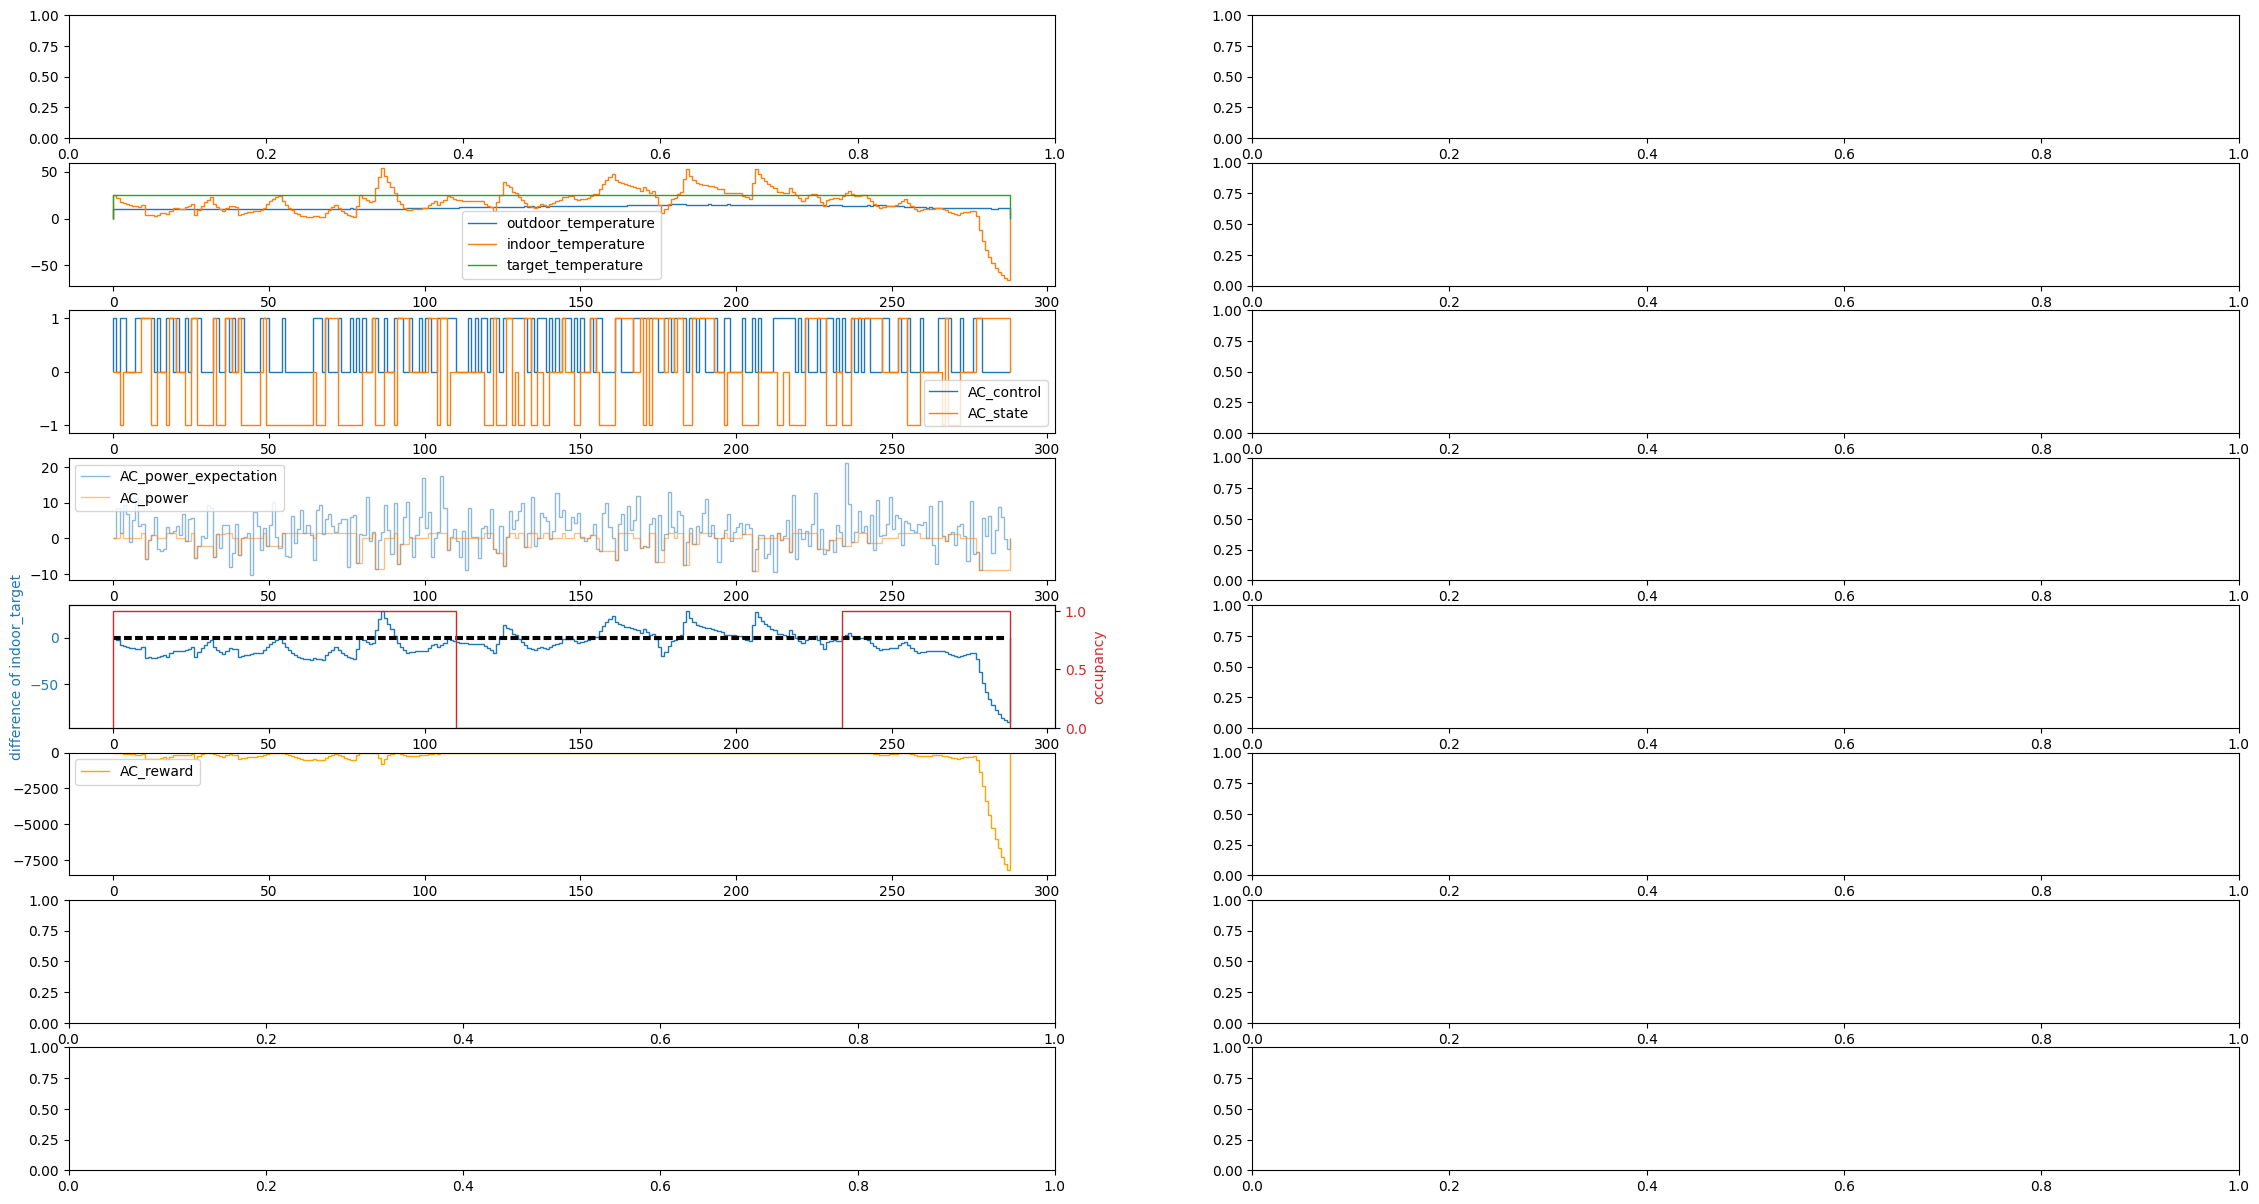

Episode 1


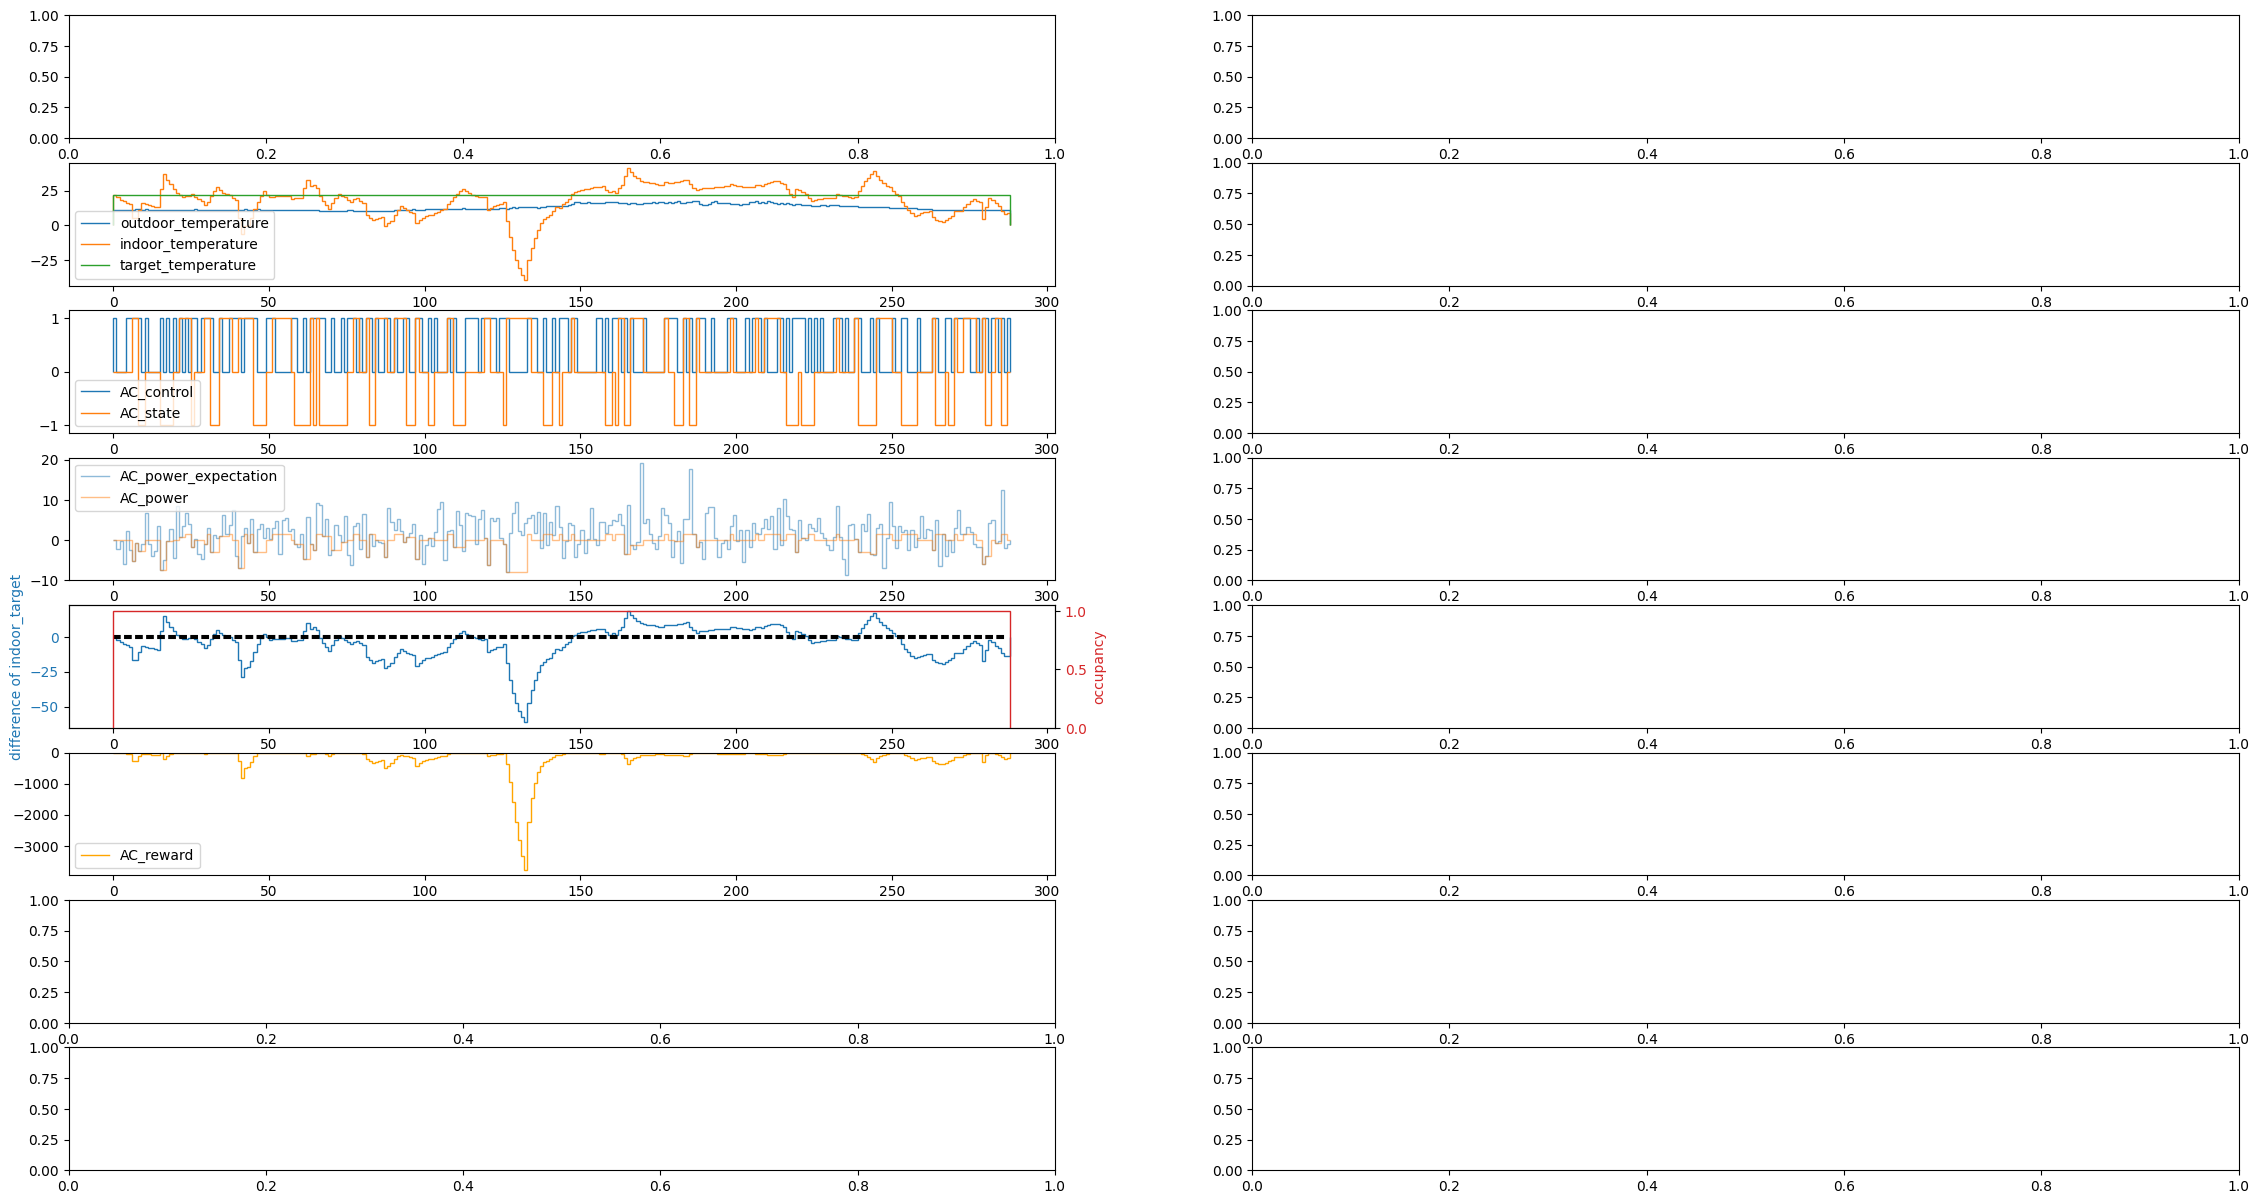

Episode 2


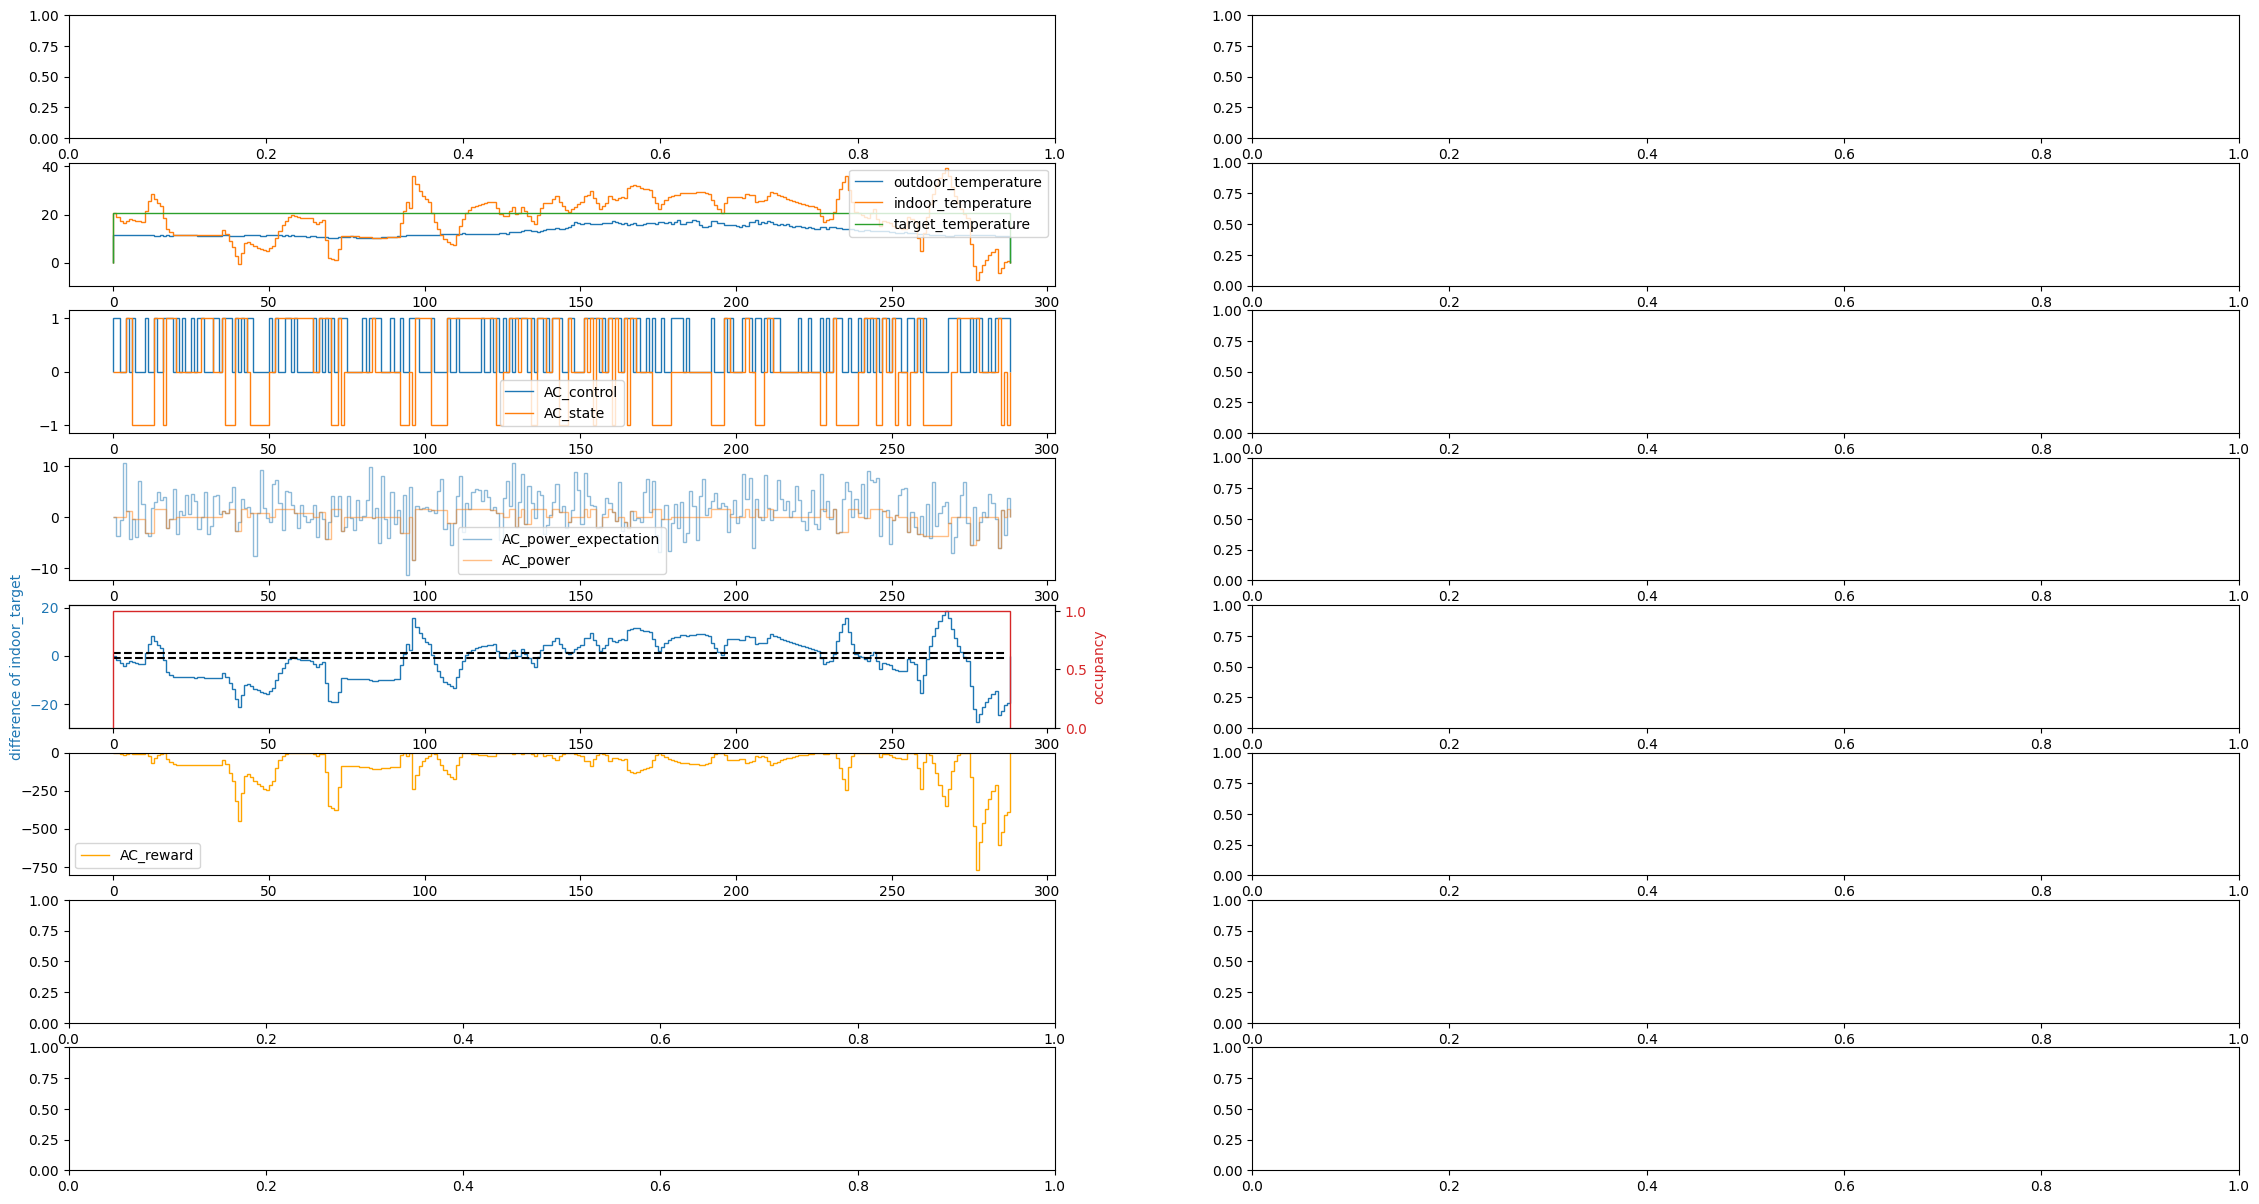

Episode 3


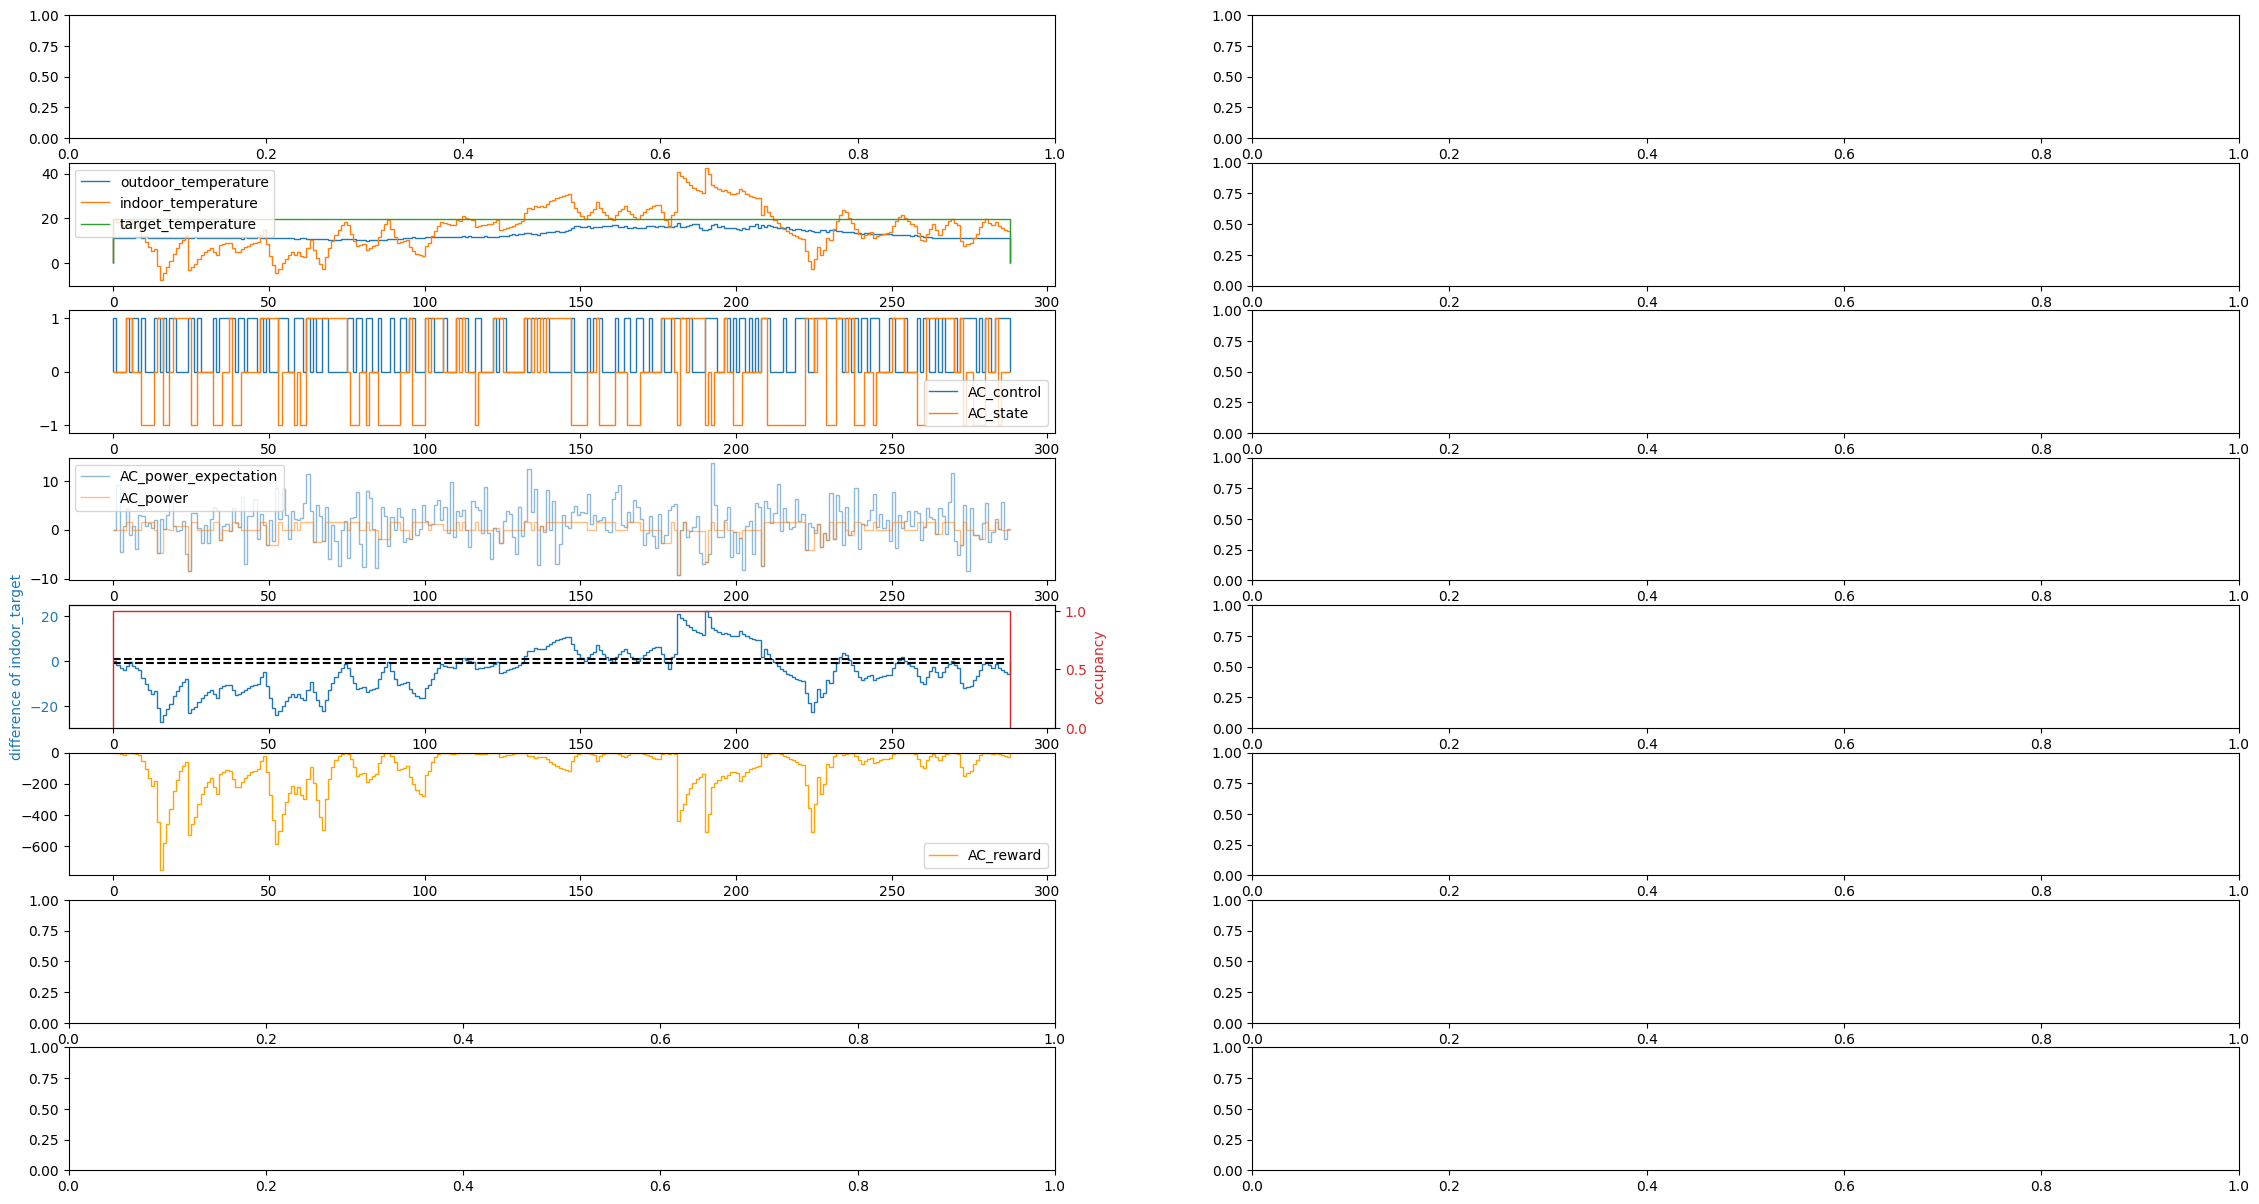

In [7]:
"""
Rendering the environment
"""
test_env = sa_env(**env_attr).unwrapped
renderer = Renderer(env=test_env, render_mode='episode')
test_env.reset()
for e in range(4):
    print(f'Episode {e}')
    env_state, _ = test_env.reset()
    agent_id = test_env.agents[0]
    state = env_state[agent_id]
    done = False

    while not done:
        action = trained_agent.take_action(state)
        env_action = {agent_id: action}
        env_next_state, env_reward, env_done, _, _ = test_env.step(env_action)
        done = env_done[agent_id]
    renderer.render()


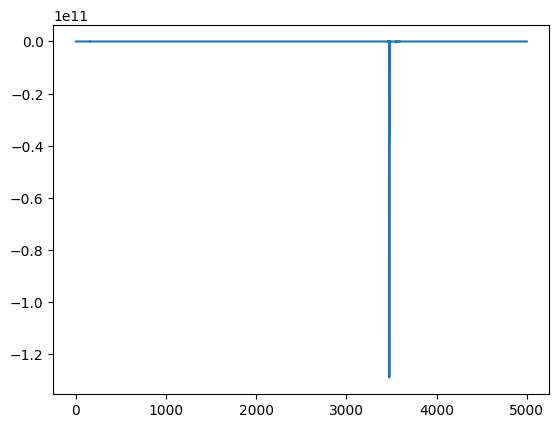

In [6]:
plt.plot(return_list)
plt.show()